In [1]:
%config Completer.use_jedi=False

In [2]:
import pytorch_lightning as pl
import torch
from torch import nn
from pl_bolts.models.autoencoders.components import (resnet18_encoder, resnet18_decoder)
from pl_bolts.datamodules import CIFAR10DataModule

from matplotlib.pyplot import imshow, figure
from matplotlib import pyplot as plt
import numpy as np
from torchvision.utils import make_grid
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization

%matplotlib inline

In [3]:
class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()
        self.save_hyperparameters()
        
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim,
            input_height=input_height,
            first_conv=False,
            maxpool1=False
        )
        
        # distr parameters
        
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)
        
        
        # for gaussian likelihood
        
        self.log_scale = nn.Parameter(torch.Tensor([0.]))
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)
    
    def gaussian_likelihood(self, x_hat, logscale, x):
        scale = torch.exp(logscale)
        mean = x_hat
        dist = torch.distributions.Normal(mean, scale)
        
        # measure prob of seeing image under p(x|z)
        log_pxz = dist.log_prob(x)
        return log_pxz.sum(dim=(1, 2, 3))
    
    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)
        
        # 2. get the probs from the eqn
        
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)
        
        # kl-div
        
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl
        
    def training_step(self, batch, batch_idx):
        x, _ = batch
        
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)
        
        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
        
        x_hat = self.decoder(z)
        
        reconstruction_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)
        kl = self.kl_divergence(z, mu, std)
        
        elbo = kl - reconstruction_loss
        elbo = elbo.mean()
        
        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': reconstruction_loss.mean(),
            'reconstruction': reconstruction_loss.mean(),
            'kl': kl.mean(),
        })
        
        return elbo

In [4]:
cifar10 = CIFAR10DataModule('./data/')

In [5]:
pl.seed_everything(1234)

vae = VAE()
trainer = pl.Trainer(gpus=1, max_epochs=2, progress_bar_refresh_rate=10)
trainer.fit(vae, cifar10)

Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
  warnings.warn(*args, **kwargs)


Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params
------------------------------------------
0 | encoder | ResNetEncoder | 11.2 M
1 | decoder | ResNetDecoder | 8.6 M 
2 | fc_mu   | Linear        | 131 K 
3 | fc_var  | Linear        | 131 K 
------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.228    Total estimated model params size (MB)
/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/torch/utils/data/dataloader.py:474: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: 0it [00:00, ?it/s]

In [32]:
class ImageSampler(pl.Callback):
    def __init__(self):
        super().__init__()
        self.img_size = None
        self.num_preds = 16

    def on_train_epoch_end(self, trainer, pl_module, outputs):
        figure(figsize=(8, 3), dpi=300)

        # Z COMES FROM NORMAL(0, 1)
        rand_v = torch.rand((self.num_preds, pl_module.hparams.latent_dim), device=pl_module.device)
        p = torch.distributions.Normal(torch.zeros_like(rand_v), torch.zeros_like(rand_v))
        z = p.rsample()

        # SAMPLE IMAGES
        with torch.no_grad():
            pred = pl_module.decoder(z.to(pl_module.device)).cpu()

        # UNDO DATA NORMALIZATION
        normalize = cifar10_normalization()
        mean, std = np.array(normalize.mean), np.array(normalize.std)
        img = make_grid(pred).permute(1, 2, 0).numpy() * std + mean

        # PLOT IMAGES
        trainer.logger.experiment.add_image('img',torch.tensor(img).permute(2, 0, 1), global_step=trainer.global_step)
        imshow(img)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
/home/ojass/anaconda3/envs/ai/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params
------------------------------------------
0 | encoder | ResNetEncoder | 11.2 M
1 | decoder | ResNetDecoder | 8.6 M 
2 | fc_mu   | Linear        | 131 K 
3 | fc_var  | Linear        | 131 K 
------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.228    Total estimated model params size (MB)


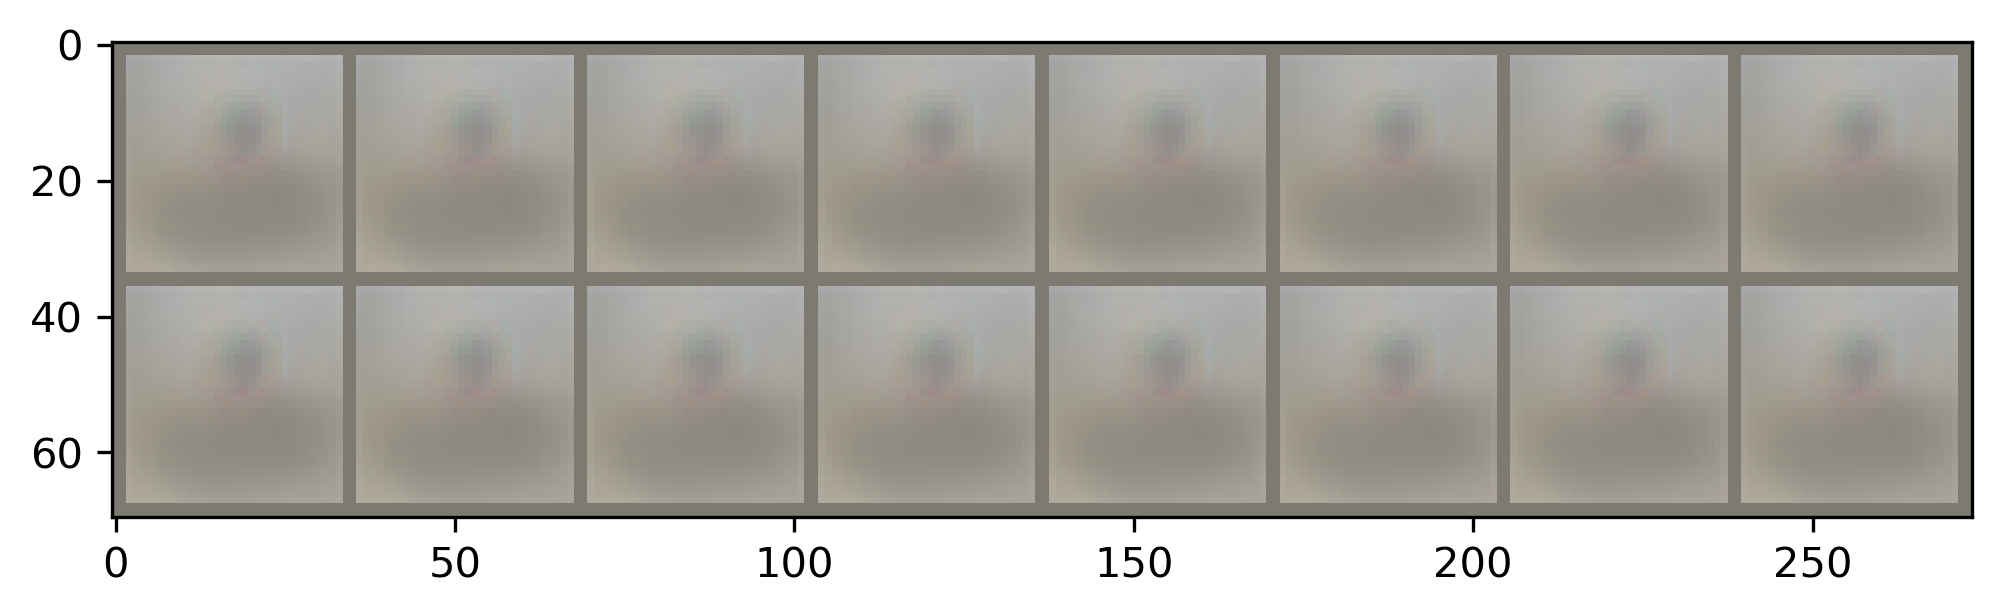

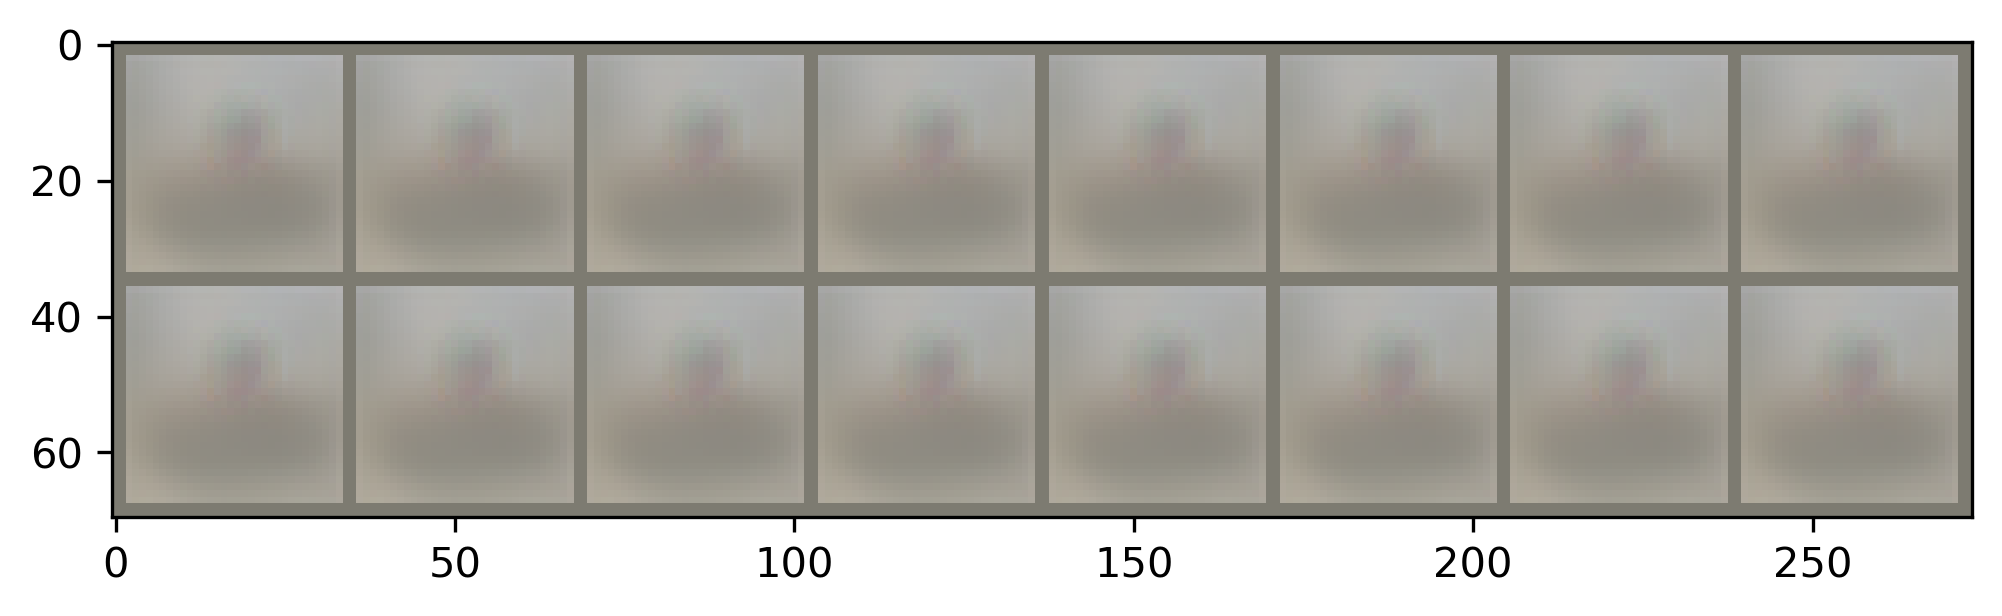

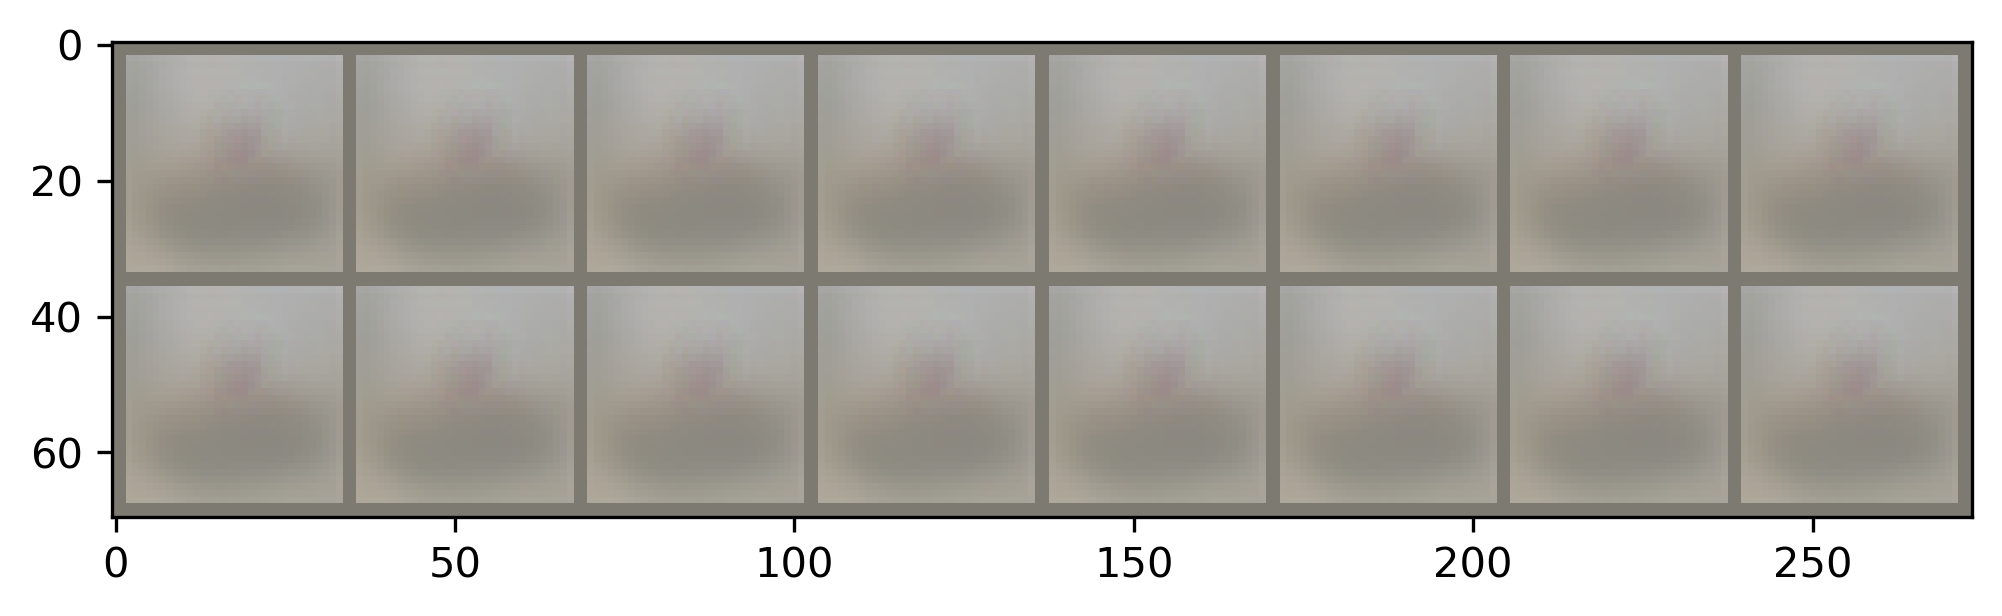

In [33]:
sampler = ImageSampler()
trainer = pl.Trainer(gpus=1, max_epochs=3, callbacks=[sampler], precision=16, amp_level='01')
trainer.fit(vae, cifar10)

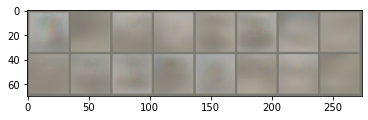

In [19]:
rand_v = torch.rand((16, vae.hparams.latent_dim), device=vae.device)
p = torch.distributions.Normal(torch.zeros_like(rand_v), torch.ones_like(rand_v), validate_args=False)
z = p.rsample()

with torch.no_grad():
    pred = vae.decoder(z.to(vae.device)).cpu()
normalize = cifar10_normalization()
mean, std = np.array(normalize.mean), np.array(normalize.std)
img = make_grid(pred).permute(1, 2, 0).numpy() * std + mean
imshow(img)

In [15]:
torch.distributions.Normal(torch.zeros_like(rand_v), torch.zeros_like(rand_v), validate_args=False)

Normal(loc: torch.Size([16, 256]), scale: torch.Size([16, 256]))